In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # графики в svg выглядят более четкими
from pylab import rcParams # увеличим дефолтный размер графиков
rcParams["figure.figsize"] = 8, 5

import warnings
warnings.filterwarnings('ignore')

## Вопрос 1
#### Направления смен тарифных планов: с каких тарифных планов и на какие шли  наибольшие перетоки? Визуализировать потоки миграций на диаграмме. 

In [2]:
tariff = pd.read_csv('Tariff_plans_change.csv', parse_dates=['START_DTTM','END_DTTM'] )

In [3]:
# обработаем данные
tariff['END_DTTM']= tariff['END_DTTM'].replace('$null$', np.NAN)
tariff['END_DTTM'] = tariff['END_DTTM'].astype('datetime64')

In [4]:
tariff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12344 entries, 0 to 12343
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   SUBSCRIBER_ID   12344 non-null  int64         
 1   TARIFF_PLAN_ID  12344 non-null  int64         
 2   START_DTTM      12344 non-null  datetime64[ns]
 3   END_DTTM        6406 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(2)
memory usage: 385.9 KB


In [5]:
print(f'Чило клиентов - {tariff.SUBSCRIBER_ID.nunique()}')

Чило клиентов - 5989


In [6]:
tariff.SUBSCRIBER_ID.value_counts().sort_values().value_counts()

2     5718
3      233
4       20
6       12
5        3
8        1
16       1
18       1
Name: SUBSCRIBER_ID, dtype: int64

### Большее количество клиентов имеют две записи в данных. Следовательно меняли тарифный план лишь однажды

### Проверим данные на дубликаты

In [7]:
# видис, что есть дубликаты в данных
tariff[tariff['SUBSCRIBER_ID'] == 5929]

,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM
12202,5929,1,2016-12-27 16:58:57,2017-01-28 15:12:12
12203,5929,1,2016-12-27 16:58:57,2017-01-28 15:12:12
12204,5929,5,2017-02-18 19:26:05,2017-03-17 10:38:22
12205,5929,5,2017-02-18 19:26:05,2017-03-17 10:38:22
12206,5929,1,2017-03-17 10:38:23,2017-03-20 18:54:34
12207,5929,1,2017-03-17 10:38:23,2017-03-20 18:54:34
12208,5929,5,2017-03-20 18:54:35,2017-03-30 12:15:37
12209,5929,5,2017-03-20 18:54:35,2017-03-30 12:15:37
12210,5929,3,2017-03-30 12:15:38,2017-04-01 07:07:50
12211,5929,3,2017-03-30 12:15:38,2017-04-01 07:07:50


In [8]:
# удалим дубликатов и обновим индексы
tariff = tariff[~tariff.duplicated()]
tariff.index = list(range(tariff.shape[0]))

In [9]:
dist_before = tariff[~tariff['END_DTTM'].isna()]['TARIFF_PLAN_ID'].value_counts(normalize=True)
dist_before

3    0.437461
1    0.322596
4    0.103237
2    0.095695
5    0.041012
Name: TARIFF_PLAN_ID, dtype: float64

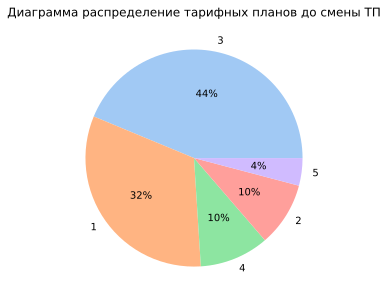

In [10]:
colors = sns.color_palette('pastel')[0:5]

plt.pie(dist_before.values, labels = dist_before.index, colors = colors, autopct='%.0f%%')
plt.title('Диаграмма распределение тарифных планов до смены ТП');

In [11]:
dist_after = tariff[tariff['END_DTTM'].isna()]['TARIFF_PLAN_ID'].value_counts(normalize=True)
dist_after

5    0.804829
4    0.139119
3    0.028533
1    0.021442
2    0.006078
Name: TARIFF_PLAN_ID, dtype: float64

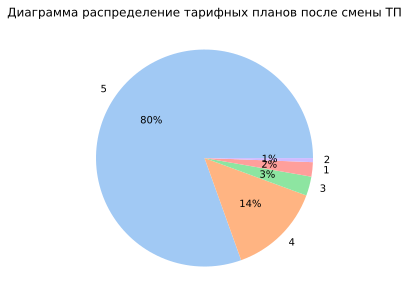

In [12]:
colors = sns.color_palette('pastel')[0:5]

plt.pie(dist_after.values, labels = dist_after.index, colors = colors, autopct='%.0f%%')
plt.title('Диаграмма распределение тарифных планов после смены ТП');

#### Видим, что распределение сильно изменилось. 
#### Теперь посмотрим на направления миграции. С какого на какой ТП клииенты переходили

In [13]:
# добавим новую колонку "NEXT_TARIFF_PLAN_ID" - на какой ТП клиент перешел
# "NaN" - клиент на данный момент пользуется текущим ТП
tariff['NEXT_TARIFF_PLAN_ID'] = [0 for i in range(tariff.shape[0])]
for indx in tariff.index[:-1]:
    current_sub_id = tariff.iloc[indx,:]['SUBSCRIBER_ID']
    next_sub_id = tariff.iloc[indx+1,:]['SUBSCRIBER_ID']
    if current_sub_id == next_sub_id:
        tariff.loc[indx, 'NEXT_TARIFF_PLAN_ID'] = tariff.iloc[indx+1,:]['TARIFF_PLAN_ID']

In [14]:
# добавим столбец "Transition_TARIFF_PLAN" - комбинация из ТП
# например "2-1" означает что клиент перешел их 2 в 3 ТП
tariff['Transition_TARIFF_PLAN'] = tariff['TARIFF_PLAN_ID'].astype(str) \
                                    +"-" \
                                    + tariff['NEXT_TARIFF_PLAN_ID'].astype(str)

In [15]:
tariff.head()

,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM,NEXT_TARIFF_PLAN_ID,Transition_TARIFF_PLAN
0,1,2,2013-11-22 21:10:08,2017-03-11 14:24:17,3,2-3
1,1,3,2017-03-11 14:24:18,NaT,0,3-0
2,2,1,2016-02-05 16:36:34,2017-06-29 12:39:58,5,1-5
3,2,5,2017-06-29 12:39:59,NaT,0,5-0
4,3,1,2015-05-06 19:17:46,2017-04-14 12:00:59,5,1-5


In [16]:
tariff['Transition_TARIFF_PLAN'] = tariff['Transition_TARIFF_PLAN'].apply(lambda x: np.NaN if '0' in x else x)

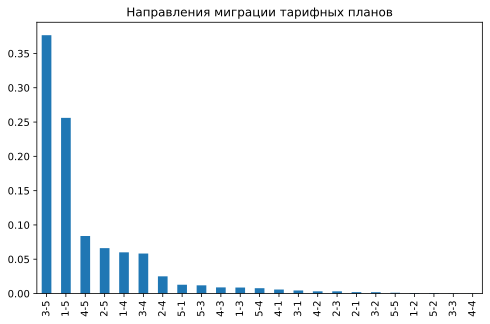

In [17]:
tariff[~tariff['Transition_TARIFF_PLAN'].isna()]['Transition_TARIFF_PLAN'].value_counts(normalize=True).plot.bar()
plt.title("Напрaвления миграции тарифных планов");

#### В основном пользователи переходили на 5-ый тарифный план

## Вопрос 2

#### Насколько изменился среднемесячный счет абонентов за период 3 месяца после месяца смены тарифного плана в сравнении с периодом 3 месяца до месяца смены тарифного плана. Какие направления смен тарифных планов характеризовались ростом среднего счета в трехмесячном периоде, а какие – сокращением.  Визуализировать результаты на диаграммах.

In [18]:
charges = pd.read_csv('Charges.csv', parse_dates=['BILL_MONTH'])

In [19]:
charges.head()

,SUBSCRIBER_ID,BILL_MONTH,CHARGES
0,4741,2017-03-01,4.572
1,1754,2017-05-01,4.894
2,381,2017-01-01,6.670
3,5832,2016-12-01,4.299
4,5277,2017-03-01,1.610


In [20]:
charges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112595 entries, 0 to 112594
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   SUBSCRIBER_ID  112595 non-null  int64         
 1   BILL_MONTH     112595 non-null  datetime64[ns]
 2   CHARGES        112595 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.6 MB


In [21]:
# сортируем данные
charges = charges.sort_values(['SUBSCRIBER_ID', 'BILL_MONTH'])

In [22]:
# создаим таблицу, где будут отражены лишь данные о движении ТП пользователей 
# т.е. отберем все строки, кроме тех, где пользователь пользуется текущим ТП
tariff_main = tariff[~tariff['Transition_TARIFF_PLAN'].isna()]
tariff_main.index = [i for i in range(tariff_main.shape[0])]
tariff_main.head()

,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM,NEXT_TARIFF_PLAN_ID,Transition_TARIFF_PLAN
0,1,2,2013-11-22 21:10:08,2017-03-11 14:24:17,3,2-3
1,2,1,2016-02-05 16:36:34,2017-06-29 12:39:58,5,1-5
2,3,1,2015-05-06 19:17:46,2017-04-14 12:00:59,5,1-5
3,4,3,2016-01-27 23:03:51,2017-01-09 19:27:50,5,3-5
4,5,1,2016-02-06 08:07:15,2017-05-08 12:39:59,5,1-5


In [23]:
# # создадим новые колонки - "mean_CHARGES_next_3m", "mean_CHARGES_back_3m"
# # для отражения средних 3-месячных расходов до и после смены ТП
# tariff_main['mean_CHARGES_next_3m'] = [np.NaN for i in range(tariff_main.shape[0])]
# tariff_main['mean_CHARGES_back_3m'] = [np.NaN for i in range(tariff_main.shape[0])]

In [24]:
# инициализируем функции для получения списка последующих и предыдущих 3-ех месяцев
def next_3_month(date):
    date_1 = datetime(year= date.year, month = date.month, day=1)
    return [(date_1 + pd.DateOffset(months=i)).date() for i in range(1,4)]
def back_3_month(date):
    date_1 = datetime(year= date.year, month = date.month, day=1)
    return [(date_1 - pd.DateOffset(months=i)).date() for i in range(1,4)]

In [25]:
# проверим корректность функции
tariff_main['END_DTTM'][0],next_3_month(tariff_main['END_DTTM'][0]),back_3_month(tariff_main['END_DTTM'][0])

(Timestamp('2017-03-11 14:24:17'),
 [datetime.date(2017, 4, 1),
  datetime.date(2017, 5, 1),
  datetime.date(2017, 6, 1)],
 [datetime.date(2017, 2, 1),
  datetime.date(2017, 1, 1),
  datetime.date(2016, 12, 1)])

In [26]:
# создадим новые колонки - "mean_CHARGES_next_3m", "mean_CHARGES_back_3m"
# для отражения средних 3-месячных расходов до и после смены ТП
for indx in tariff_main.index:
    sub_id = tariff_main.iloc[indx,:]['SUBSCRIBER_ID']
    
    list_dates_next = next_3_month(tariff_main.iloc[indx,:]['END_DTTM'])
    next_df = charges[charges['BILL_MONTH'].isin(list_dates_next)]
    next_values = next_df[next_df['SUBSCRIBER_ID'] == sub_id]['CHARGES']
    tariff_main.loc[indx, 'mean_CHARGES_next_3m'] = next_values.mean()
    

    list_dates_back = back_3_month(tariff_main.iloc[indx,:]['END_DTTM'])
    back_df = charges[charges['BILL_MONTH'].isin(list_dates_back)]
    back_values = back_df[back_df['SUBSCRIBER_ID'] == sub_id]['CHARGES']
    tariff_main.loc[indx, 'mean_CHARGES_back_3m'] = back_values.mean()

In [27]:
tariff_main[['mean_CHARGES_next_3m','mean_CHARGES_back_3m']].isna().sum()

mean_CHARGES_next_3m     0
mean_CHARGES_back_3m    19
dtype: int64

#### Видим что для 19 позиций отсутствуют расходы за последние 3 месяца до смены ТП. Поэтому не будем их учитывать при анализе

In [28]:
tariff_main_2 = tariff_main[~tariff_main['mean_CHARGES_back_3m'].isna()]

In [29]:
# средний расход после смены ТП
tariff_main_2['mean_CHARGES_next_3m'].mean()

6.811059298189756

In [30]:
# средний расход до смены ТП
tariff_main_2['mean_CHARGES_back_3m'].mean()

8.642141848489684

### Изменения составили ~ -1.8

In [31]:
# добавим колонку "diff_next_back" - разницу между периодами по расходам
tariff_main_2['diff_next_back'] = tariff_main_2['mean_CHARGES_next_3m'] - tariff_main_2['mean_CHARGES_back_3m']

In [32]:
Transition_charges = tariff_main_2.groupby('Transition_TARIFF_PLAN')['diff_next_back'].mean().sort_values()
Transition_charges

Transition_TARIFF_PLAN
5-5   -4.627905
2-3   -3.348283
3-4   -2.412072
5-4   -2.320929
3-5   -2.176663
1-5   -2.066912
1-4   -1.852773
2-4   -1.753408
2-5   -1.634030
1-3   -1.260509
3-3   -1.167333
1-2   -1.139267
2-1   -0.946949
3-1   -0.822607
5-1   -0.775825
4-5   -0.366195
4-3    0.023448
4-4    0.238000
5-3    0.419887
4-1    0.760396
4-2    0.801367
5-2    1.023000
3-2    2.793472
Name: diff_next_back, dtype: float64

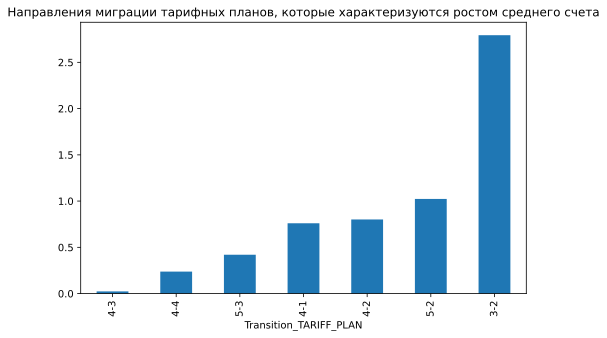

In [33]:
Transition_charges[Transition_charges > 0].plot.bar()
plt.title("Направления миграции тарифных планов, которые характеризуются ростом среднего счета");

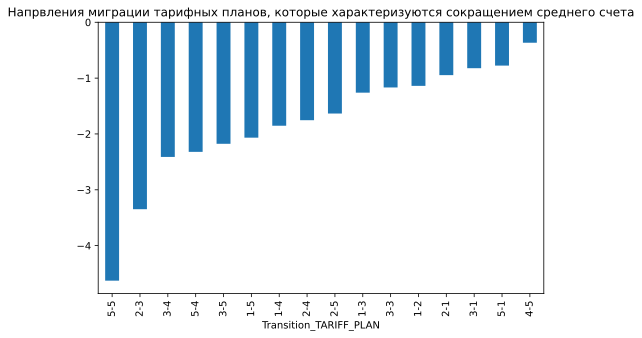

In [34]:
Transition_charges[Transition_charges < 0].plot.bar()
plt.title("Напрвления миграции тарифных планов, которые характеризуются сокращением среднего счета");

## 3 вопрос

In [35]:
suspended = pd.read_csv('Suspended.csv', parse_dates=['START_DT','END_DT'])

In [36]:
suspended['END_DT']= suspended['END_DT'].replace('$null$', np.NAN)
suspended['END_DT'] = suspended['END_DT'].astype('datetime64')

In [37]:
suspended.sort_values(['SUBSCRIBER_ID'])

,SUBSCRIBER_ID,START_DT,END_DT,STATUS
2768,5,2017-06-16,2017-06-29,Suspended
2817,5,2017-03-23,2017-04-15,Suspended
2914,5,2016-09-19,2016-09-28,Suspended
2961,5,2016-07-25,2016-08-14,Suspended
2718,5,2017-07-31,2017-08-14,Suspended
...,...,...,...,...
3903,5987,2017-05-19,2017-05-22,Suspended
3891,5987,2017-05-28,2017-06-16,Suspended
3309,5988,2017-09-25,2017-10-08,Suspended
3374,5988,2017-07-23,2017-07-23,Suspended


In [38]:
suspended.STATUS.value_counts()

Suspended    4063
Name: STATUS, dtype: int64

In [39]:
suspended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4063 entries, 0 to 4062
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SUBSCRIBER_ID  4063 non-null   int64         
 1   START_DT       4063 non-null   datetime64[ns]
 2   END_DT         3997 non-null   datetime64[ns]
 3   STATUS         4063 non-null   object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 127.1+ KB


In [40]:
# Создадим след колонки:
# "Count_suspend_after_trans" - количество блокировок за последние 3 мес перед сменой ТП
# "Count_suspend_before_trans" - количество блокировок за последние 3 мес после смены ТП

def plus_3_month(date):
    return (date + pd.DateOffset(months=3)).date()
def minus_3_month(date):
    return (date - pd.DateOffset(months=3)).date()

for indx in tariff_main.index:
    sub_id = tariff_main.iloc[indx,:]['SUBSCRIBER_ID']
    df_suspend = suspended[suspended['SUBSCRIBER_ID'] == sub_id]
    
    # даты для "Count_suspend_after_trans"
    start_date_next = tariff_main.iloc[indx,:]['END_DTTM']
    end_date_next = plus_3_month(start_date_next)

    # даты для "Count_suspend_before_trans"
    end_date_back = tariff_main.iloc[indx,:]['END_DTTM']
    start_date_back = minus_3_month(end_date_back)

    
    tariff_main.loc[indx, 'Count_suspend_after_trans'] = df_suspend[df_suspend['START_DT']\
                                                        .dt.date.between(start_date_next,
                                                                         end_date_next)].shape[0]
    tariff_main.loc[indx, 'Count_suspend_before_trans'] = df_suspend[df_suspend['START_DT']\
                                                        .dt.date.between(start_date_back,
                                                                         end_date_back)].shape[0]

tariff_main['Count_suspend_after_trans'] =tariff_main['Count_suspend_after_trans'].astype('int')    
tariff_main['Count_suspend_before_trans'] =tariff_main['Count_suspend_before_trans'].astype('int')   

In [41]:
count_suspend_before = tariff_main['Count_suspend_before_trans'].sum()
print(f'Количество блокировок перед сменой ТП за последние 3 месяца до смены - {count_suspend_before}')

Количество блокировок перед сменой ТП за последние 3 месяца до смены - 919


In [42]:
count_suspend_after = tariff_main['Count_suspend_after_trans'].sum()
print(f'Количество блокировок спустя 3 месяца после смены ТП - {count_suspend_after}')

Количество блокировок спустя 3 месяца после смены ТП - 635


In [43]:
num = int(round((100 - count_suspend_after/count_suspend_before*100),0))
print(f'Количество блокировок уменьшилось на {num}%')

Количество блокировок уменьшилось на 31%


In [44]:
df_Count_suspend = tariff_main.groupby("Transition_TARIFF_PLAN")[['Count_suspend_before_trans','Count_suspend_after_trans']].sum()\
.sort_values('Count_suspend_before_trans', ascending=False)
df_Count_suspend

,Count_suspend_before_trans,Count_suspend_after_trans
Transition_TARIFF_PLAN,,
3-5,313,157
1-5,167,113
4-5,144,104
3-4,130,78
1-4,70,47
4-3,18,16
5-3,14,23
5-4,13,10
3-2,10,1


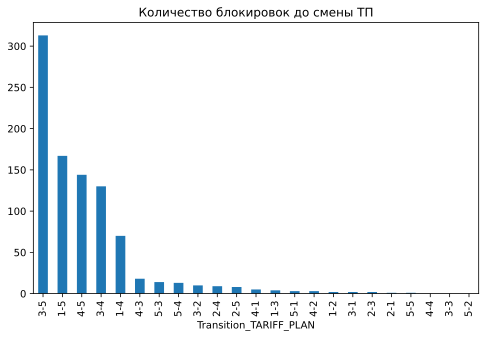

In [45]:
df_Count_suspend['Count_suspend_before_trans'].plot.bar()
plt.title("Количество блокировок до смены ТП");

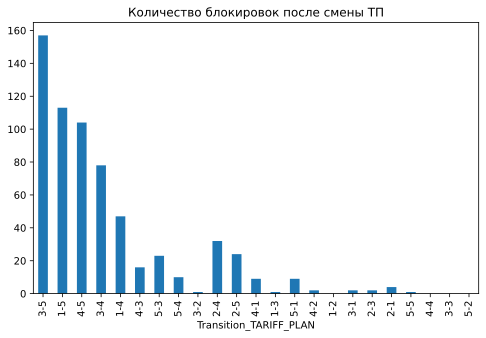

In [46]:
df_Count_suspend['Count_suspend_after_trans'].plot.bar()
plt.title("Количество блокировок после смены ТП");